In [1]:
import math

import numpy as np
import torch
import torchvision.utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity

In [2]:
def imsshow(imgs, titles=None, num_col=5, dpi=100, cmap=None, is_colorbar=False, is_ticks=False):
    '''
    assume imgs's shape is (Nslice, Nx, Ny)
    '''
    num_imgs = len(imgs)
    num_row = math.ceil(num_imgs / num_col)
    fig_width = num_col * 3
    if is_colorbar:
        fig_width += num_col * 1.5
    fig_height = num_row * 3
    fig = plt.figure(dpi=dpi, figsize=(fig_width, fig_height))
    for i in range(num_imgs):
        ax = plt.subplot(num_row, num_col, i + 1)
        im = ax.imshow(imgs[i], cmap=cmap)
        if titles:
            plt.title(titles[i])
        if is_colorbar:
            cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.01, ax.get_position().height])
            plt.colorbar(im, cax=cax)
        if not is_ticks:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()
    plt.close('all')

## Dataset

We select 200 cines from ACDC datasets, presented by a numpy array `(200, 20, 192, 192)`.

Preprocessing steps:

1. Discarded first and last 3 slices,
2. Truncated time dimensions to 20,
3. Croped and padded to 192x192,
4. Min-max normalized on each dynamic image.

Finally, we stacked all cines together, random permutated, selected first 200 cines.  

In [3]:
dataset = np.load('./cine.npz')['dataset']
print(f"The shape of dataset is {dataset.shape}.")
print(f"The type of dataset is {dataset.dtype}.")

The shape of dataset is (200, 20, 192, 192).
The type of dataset is float32.


Cine's min: 0.0, max: 1.0


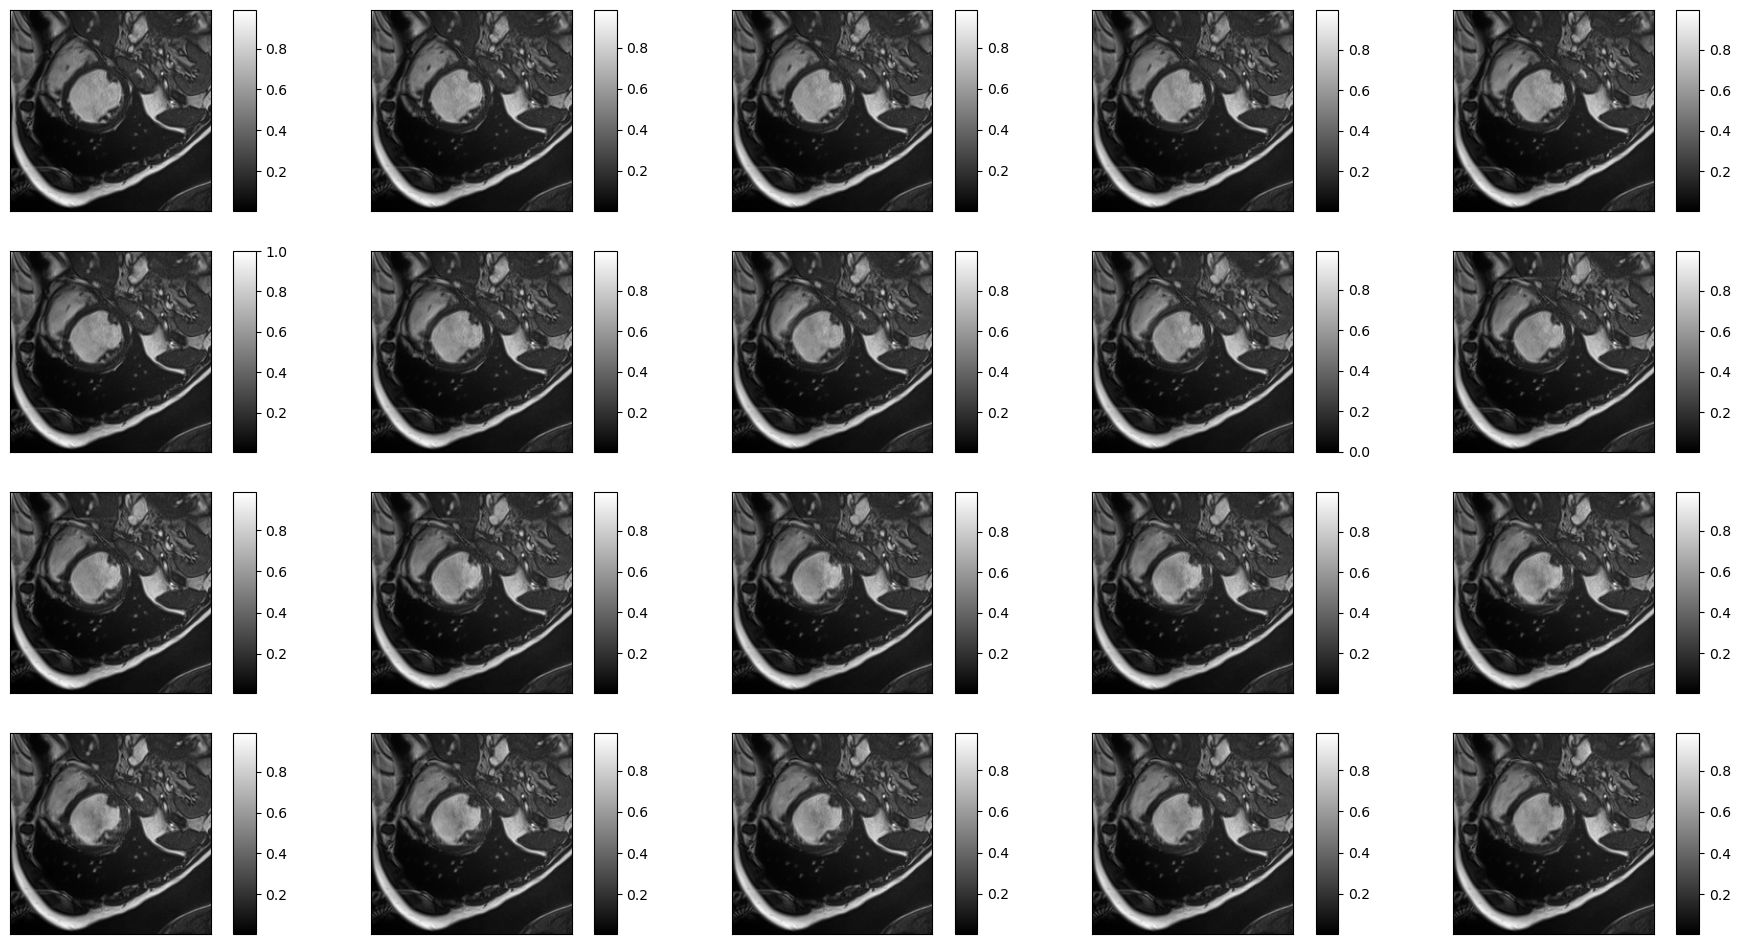

In [4]:
# example cine
CINE_INDEX = 100
assert CINE_INDEX >= 0 and CINE_INDEX < 200
cine = dataset[CINE_INDEX]
print(f"Cine's min: {cine.min()}, max: {cine.max()}")
imsshow(cine, num_col=5, cmap='gray', is_colorbar=True)

## variable-density undersampling mask

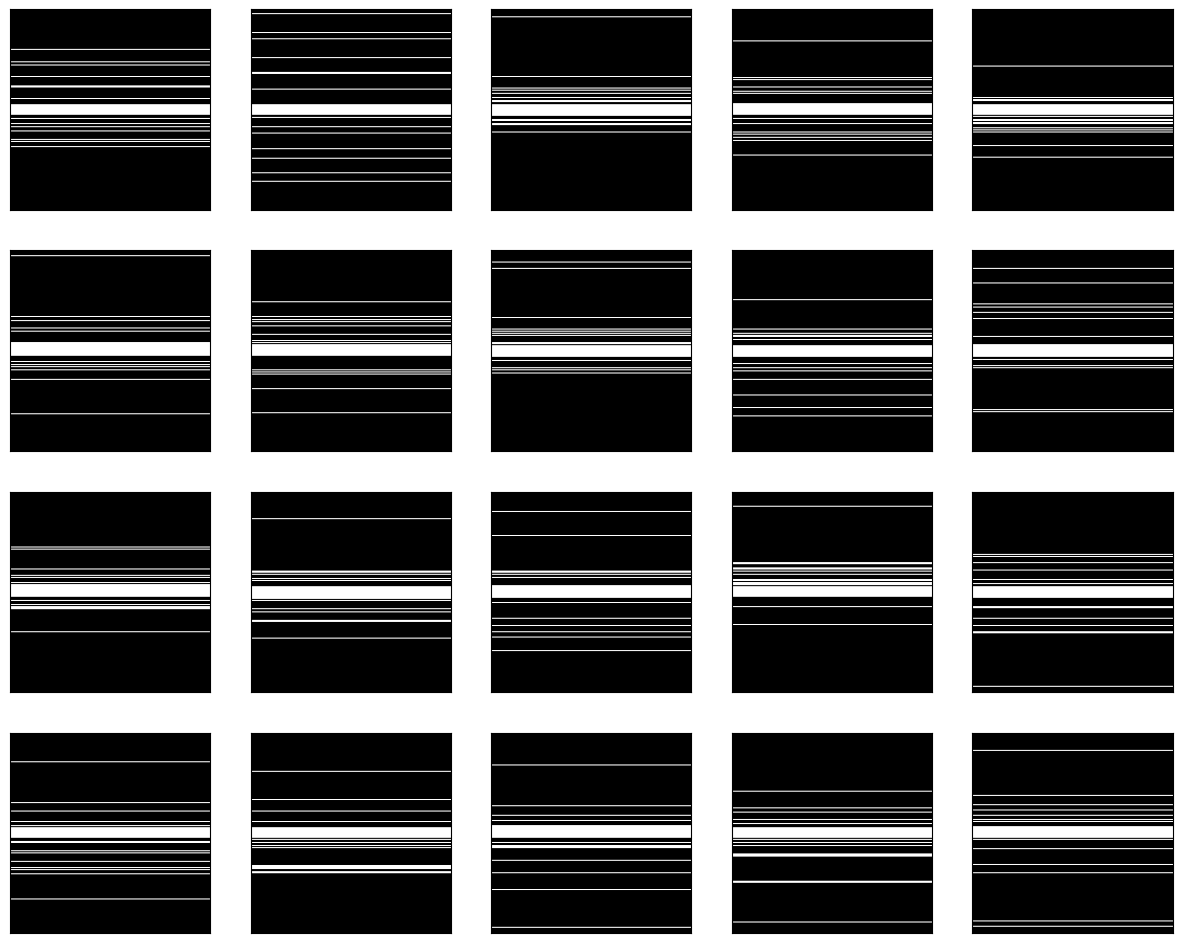

In [5]:
from CS_mask import cartesian_mask

mask = cartesian_mask(shape=(1, 20, 192, 192), acc=8, sample_n=10, centred=True)
imsshow(mask[0, :, :, :], num_col=5, cmap='gray')

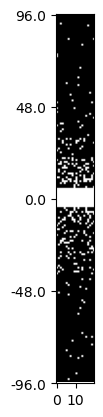

In [15]:
#Plot the undersampling masks in the ky-t dimension.
mask = cartesian_mask(shape=(1, 20, 192, 192), acc=8, sample_n=10, centred=True)
#获取每个mask为1的位置，存在一个矩阵里,Ai,j=1表示第i个mask的第j行为1
kyt=np.ones((192,20))
for i in range(20):
    zeros=np.where(mask[0,i,:,:]==0)
    kyt[zeros[0],i]=0
plt.imshow(kyt,cmap='gray')
#把纵坐标设置成从96到-96，注意96在上方
plt.yticks(np.linspace(0,192,5),np.linspace(96,-96,5))
plt.show()


In [7]:
#傅里叶变换
def fft2c(img):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
#傅里叶逆变换
def ifft2c(img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(img)))

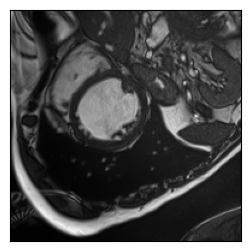

In [8]:
test=cine[0]
imsshow([test], num_col=1, cmap='gray')

In [9]:
test_mask=mask[0,0,:,:]

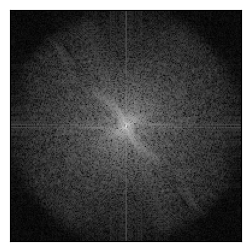

In [10]:
#对图像进行傅里叶变换，并展示其频谱
test_fft=fft2c(test)
test_fft_abs=np.abs(test_fft)
test_fft_abs_log=np.log(test_fft_abs+1)
imsshow([test_fft_abs_log], num_col=1, cmap='gray')

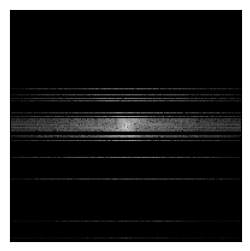

In [11]:
test_ksp=fft2c(test)
test_ksp=test_ksp*test_mask
test_ksp_abs=np.abs(test_ksp)
test_ksp_abs=np.log(test_ksp_abs+1)
imsshow([test_ksp_abs], num_col=1, cmap='gray')

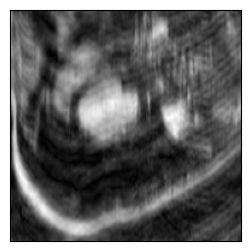

In [12]:
test_recon=ifft2c(test_ksp)
test_recon_abs=np.abs(test_recon)
imsshow([test_recon_abs], num_col=1, cmap='gray')